<a href="https://colab.research.google.com/github/GurneeshBudhiraja/ArangoDB-Hackathon/blob/main/main_cuGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installs the Required Dependencies


In [2]:
!pip install -U pandas
!pip install -U matplotlib
!pip install -U python-dotenv

!pip install nx-arangodb
!pip install arango-datasets
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com

!pip install google-genai
!pip install langchain-openai
!pip install langchain-mistralai

!pip install langchain
!pip install langchain-google-genai
!pip install -U langchain-community
!pip install langgraph

!pip install python-louvain
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.5 MB/s eta 0:00:00


### Imports the packages


In [3]:
# Import required modules
import json
import os
from pydantic import BaseModel, Field
from typing import Optional, List, Dict, Tuple, Literal, Union, Any
from typing_extensions import Annotated, TypedDict
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate
import pprint



import networkx as nx
import nx_arangodb as nxadb
from pathlib import Path
from dotenv import load_dotenv
import cudf
import cugraph


from arango import ArangoClient
from arango_datasets import Datasets
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.graphs import ArangoGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI
from langchain.chains import ArangoGraphQAChain
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from langchain.chains import ArangoGraphQAChain
import community as community_louvain




# Gemini SDK Packages
from google import genai

# OpenAI SDK Packages
from openai import OpenAI

[04:30:41 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


### Loads the env variables


In [93]:
from google.colab import userdata


ARANGO_HOST = userdata.get("ARANGO_HOST")
ARANGO_PASSWORD = userdata.get("ARANGO_PASSWORD")
ARANGO_USERNAME = userdata.get("ARANGO_USERNAME")
GEMINI_API = userdata.get("GEMINI_API_KEY")
OPENAI_API_KEY = userdata.get("OPEN_API_KEY")
MISTRAL_API_KEY = userdata.get("MISTRAL_API_KEY")

LANGSMITH_TRACING=True
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"

LANGSMITH_API_KEY=userdata.get("LANGSMITH_API_KEY")
LANGSMITH_PROJECT=userdata.get("LANGSMITH_PROJECT")

### GPU and cuda info

In [94]:
!nvidia-smi
!nvcc --version

Sat Mar  8 05:13:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P0             27W /   70W |     170MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Initialize the ArangoDB Connection, LLM Instance, and initializing the constants


##### ArangoDB Connection


In [95]:
arango_client = ArangoClient(hosts=ARANGO_HOST).db(username=ARANGO_USERNAME, password=ARANGO_PASSWORD, verify=True)

#### Gemini and OpenAI SDK Instance


In [96]:
gemini_client = genai.Client(
    api_key=GEMINI_API
)

openai_client = OpenAI(
    api_key=OPENAI_API_KEY
)

#### Model Names' Constants


In [97]:
# Gemini models
GEMINI_FLASH_MODEL = "gemini-2.0-flash"
GEMINI_FLASH_LITE_MODEL = "gemini-2.0-flash-lite"
GEMINI_PRO_MODEL = "gemini-1.5-pro"

# OpenAI Model
GPT_4O = "gpt-4o-2024-08-06"


# MistralAI Model
MISTRAL_LARGE="mistral-large-latest"


### Conditionally loads the SYNTHEA_P100 dataset in ArangoDB and creates an ArangoGraph instance using ArangoDB instance


#### Loads the dataset in ArangoDB


In [98]:
datasets = Datasets(arango_client)

DATASET_NAME = "SYNTHEA_P100"

# Conditionally Loads the Synthea P100 dataset in Arango
if not arango_client.has_graph(DATASET_NAME):
  datasets.load(dataset_name=DATASET_NAME)
else:
  print(f"{DATASET_NAME} is already in ArangoDB.")

Output()

SYNTHEA_P100 is already in ArangoDB.


#### Creates an ArangoGraph instance using the Arango DB instance


In [99]:
# Connects with the Graph in ArangoDB
graph = None
if arango_client.has_graph(DATASET_NAME):
  graph = nxadb.Graph(name="SYNTHEA_P100",db=arango_client)
else:
  print("Graph does not exist in Arango DB")

print(graph)

[05:13:35 +0000] [INFO]: Graph 'SYNTHEA_P100' exists.
INFO:nx_arangodb:Graph 'SYNTHEA_P100' exists.
[05:13:35 +0000] [INFO]: Default node type set to 'allergies'
INFO:nx_arangodb:Default node type set to 'allergies'


Graph named 'SYNTHEA_P100' with 145514 nodes and 311701 edges


#### Graph Schema


In [100]:
arango_graph = ArangoGraph(db=arango_client)

#### Graph Plot


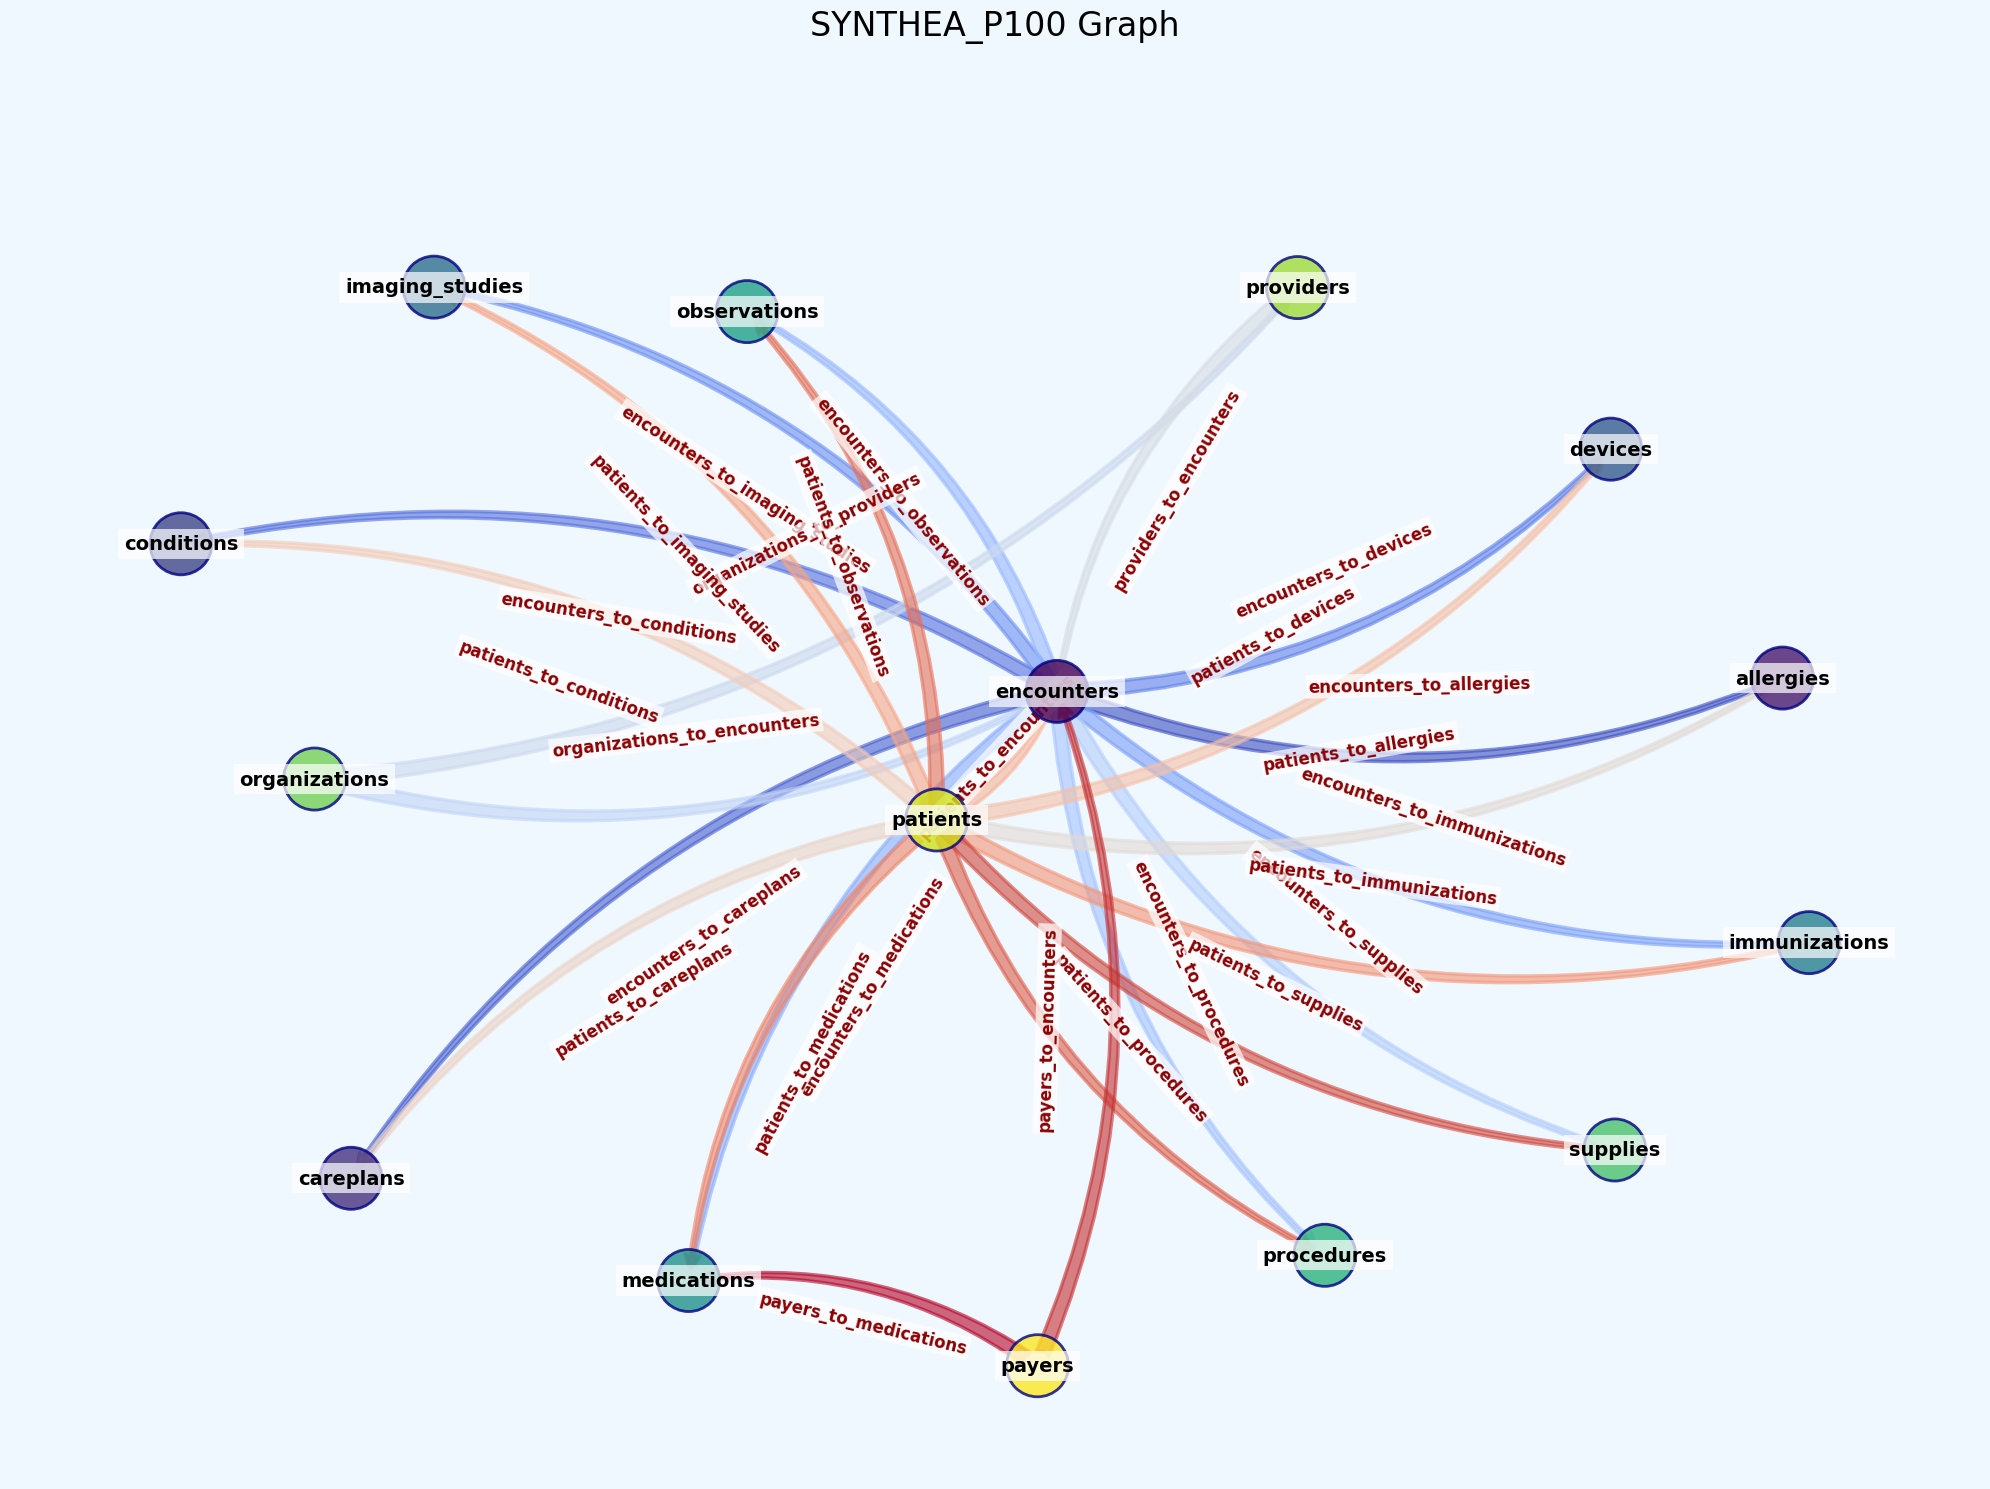

In [101]:
# Extract graph schema and edge definitions from schema data
graph_schema = arango_graph.schema["Graph Schema"][0]
edge_definitions = graph_schema["edge_definitions"]


# Create directed graph and add edges based on vertex collections
G_schema = nx.DiGraph()
for ed in edge_definitions:
    edge_collection = ed["edge_collection"]
    from_list = ed["from_vertex_collections"]
    to_list = ed["to_vertex_collections"]
    for f in from_list:
        for t in to_list:
            G_schema.add_edge(f, t, label=edge_collection)


# Set the layout for the graph visualization
pos = nx.spring_layout(G_schema, k=2, seed=42)


# Create figure with light blue background
plt.figure(figsize=(20, 15), facecolor='#f0f8ff')


# Draw nodes with color gradient
node_colors = plt.cm.viridis(np.linspace(0, 1, len(G_schema.nodes())))
nx.draw_networkx_nodes(
    G_schema, pos,
    node_size=2000,
    node_color=node_colors,
    edgecolors='navy',
    linewidths=2.0,
    alpha=0.8
)


# Draw edges with color gradient and curved arrows
edge_colors = plt.cm.coolwarm(np.linspace(0, 1, len(G_schema.edges())))
nx.draw_networkx_edges(
    G_schema, pos,
    arrowstyle='fancy',
    arrowsize=25,
    edge_color=edge_colors,
    width=2.5,
    connectionstyle='arc3,rad=0.2',
    alpha=0.6
)


# Add node labels with white background
nx.draw_networkx_labels(
    G_schema, pos,
    font_size=14,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=4)
)


# Add edge labels with white background
edge_labels = nx.get_edge_attributes(G_schema, 'label')
nx.draw_networkx_edge_labels(
    G_schema, pos,
    edge_labels=edge_labels,
    font_color='darkred',
    font_size=12,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2)
)

plt.title("SYNTHEA_P100 Graph", fontsize=24, pad=100)
plt.axis("off")
plt.tight_layout()


plt.grid(True, linestyle='--', alpha=0.5)

plt.show()



### AQL Agent


In [102]:
def aql_agent(user_query:str):
  # LLM
  aql_llm = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_LITE_MODEL,
    api_key=GEMINI_API,
    temperature=0.2,
  )

  print("=============== Running the ArangoGraphQAChain ===============")
  chain = ArangoGraphQAChain.from_llm(
    llm=aql_llm,
    graph=arango_graph,
    verbose=True,
    allow_dangerous_requests=True,
    )

  aql_chain_response = chain.invoke([HumanMessage(content=user_query)])
  return aql_chain_response


### Louvain Agent

- The agent is used to handle queries that are best to be solved using the Louvain Agent


#### Tools for the Louvain Agent


#### Defining the tools


#### Tool Schemas


In [103]:
class ExtractDataSchema(BaseModel):
    entity_type: str
    filter: str
    analysis: str

#### Louvian Agent Tools


In [104]:
# Global variable for the visualisation tool
visaulise_G = None
visaulise_partition = None

@tool
def extract_data(user_query:str):
  """
    The tool takes in the initial user_query and returns a dictionary with the following keys:
    - "entity_type": the type of entity the query is about (e.g., "patients", "providers", or "medications").
    - "filter": any specific filter criteria mentioned in the query (for example, "shared_conditions" if the query mentions shared conditions) and otherwise "none"
    - "analysis": the type of analysis to perform; since this is the community detection agent, this should always be "community_detection".
  """

  print(f"\n\n=============== Using the extract_data tool ===============\nExtracting entity_type, filter, and shared_conditions from the following user_query:\n{user_query}\n")

  # LLM
  llm = ChatGoogleGenerativeAI(
    temperature=0.2,
    api_key=GEMINI_API,
    model=GEMINI_FLASH_MODEL,
    verbose=True
  )

  output_parser = JsonOutputParser(pydantic_object=ExtractDataSchema)

  llm_prompt = PromptTemplate(
    template="""
      You are an expert in data analytics and network analysis. When given a user query related to community detection in a graph (for example, the Synthea_P100 dataset), you should extract and return a structured JSON output containing the following keys:
        - "entity_type": the type of entity the query is about (e.g., "patients", "providers", or "medications").
        - "filter": any specific filter criteria mentioned in the query (for example, "shared_conditions" if the query mentions shared conditions) and otherwise "none"
        - "analysis": the type of analysis to perform; since this is the community detection agent, this should always be "community_detection"..Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.
    """,
    input_variables=["user_query"],
    partial_variables={"format_instructions": output_parser.get_format_instructions()},
  )

  chain = llm_prompt | llm | output_parser
  chain_response = chain.invoke({"user_query": user_query})
  print("\n\n================== extract_data tool Response ==================")
  print(chain_response)
  print("\n\n")
  return chain_response

@tool
def louvain_aql_generator(user_query:str, entity_type:str, filter:str, analysis:str):
  """
    The tool is used to generate an AQL query and returns the results for the other tools.

    Args:
      user_query: str = The user query asked by the user.
      entity_type: str = Entity type generated using the other tool
      filter: str = filter from the initial user query.
      analysis: str = analysis from the user query.

    Returns:
      Response after the execution of the generated AQL query.
  """
  print(f"\n\n=============== Using the louvain_aql_generator tool ===============\n")

  # GEMINI Model
  louvain_aql_llm = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.2,
  )

  # OpenAI Model
  # louvain_aql_llm = ChatOpenAI(
  #   model=GPT_4O,
  #   api_key=OPENAI_API_KEY,
  #   temperature=0.2,
  # )

  # Mistral Model
  # louvain_aql_llm = ChatMistralAI(
  #   model=MISTRAL_LARGE,
  #   api_key=MISTRAL_API_KEY,
  #   temperature=0.5,
  # )

  aql_chain = ArangoGraphQAChain.from_llm(
    llm=louvain_aql_llm,
    graph=graph,
    verbose=True,
    allow_dangerous_requests=True,
  )
  aql_chain.return_aql_result = True

  aql_chain_response = aql_chain.invoke(f"""
    This is the user query asked by the user: {user_query} and this is the data that is extracted by the AI model from the query:
      entity_type: {entity_type}
      filter: {filter}
      analysis: {analysis}
    Your job is to
  """)


  return aql_chain_response

@tool
def build_graph(edge_list: List[Dict[str, Any]]) -> tuple:
    """
    Builds a NetworkX graph from the edge list and applies the Louvain algorithm
    to detect communities.

    Args:
        edge_list (List[Dict[str, Any]]): A list of dictionaries, where each dictionary contains:
            - "source": The ID of the source node (e.g., string).
            - "target": The ID of the target node (e.g., string).
            This list represents the edges between nodes in the graph.

    Returns:
        G (networkx.Graph): The constructed graph with nodes and edges.
        partition (dict): A dictionary mapping each node ID to its detected community.
            - The key is the node ID (e.g., "providers/0019b658-e00c-37c0-9344-339827a460c9").
            - The value is the community ID (e.g., an integer like 0, 1, 2, etc.), representing the community to which the node belongs.
    """
    global visaulise_G, visaulise_partition
    print(f"\n\n=============== Using the build_graph tool ===============\n")
    print(edge_list)
    # Construct the graph
    G = nx.Graph()
    for edge in edge_list:
        G.add_edge(edge["source"], edge["target"])

    # Apply Louvain algorithm to detect communities
    partition = community_louvain.best_partition(G)

    # Assigns the visualise_G and visualise_partition to G and partition
    visaulise_G = G
    visaulise_partition = partition

    return G, partition


def visualize_communities() -> None:
    """
    Visualizes the graph G with nodes colored by community based on the partition.

    Args:
      None: This function uses the global variables visaulise_G and visaulise_partition to plot the graph

    Returns:
        None: This function only plots the graph and doesn't return any value.
    """
    print(f"\n\n=============== Using the visualize_communities tool ===============\n")

    # Generate the layout for the graph
    pos = nx.spring_layout(visaulise_G, k=0.2, iterations=50)

    plt.figure(figsize=(20, 20))

    # Get unique community labels and assign a color for each community
    communities = set(visaulise_partition.values())
    colors = plt.cm.rainbow([i/len(communities) for i in range(len(communities))])
    community_color_map = {com: color for com, color in zip(communities, colors)}

    # Draw nodes with color based on community
    for node, community in visaulise_partition.items():
        nx.draw_networkx_nodes(
            visaulise_G,
            pos,
            nodelist=[node],
            node_color=[community_color_map[community]],
            node_size=500,
            alpha=0.8
        )

    # Draw edges in gray
    nx.draw_networkx_edges(visaulise_G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(visaulise_G, pos, font_size=8)

    plt.title("Community Detection using Louvain")
    plt.axis('off')
    plt.show()


#### Starter function for the Community Detection Louvain Agent


In [105]:

def louvain_agent(user_query:str):
  # Agent tools
  louvain_agent_tools = [extract_data,louvain_aql_generator, build_graph]

  # =========== Gemini Model ===========
  # model = init_chat_model(
  #   model=GEMINI_FLASH_MODEL,
  #   temperature=0.2,
  #   model_provider="google_genai",
  #   api_key=GEMINI_API
  # )

  # =========== OPEN AI Model ===========
  model = init_chat_model(
    model=GPT_4O,
    temperature=0.4,
    model_provider="openAI",
    api_key=OPENAI_API_KEY
  )

  # =========== MistralAI Model ===========

  # model = init_chat_model(
  #   model=MISTRAL_LARGE,
  #   temperature=0.4,
  #   model_provider="mistralai",
  #   api_key=MISTRAL_API_KEY
  # )

  agent_executor = create_react_agent(
    model=model,
    tools=louvain_agent_tools,
    prompt="""
      You are the community_detection_louvain_agent. Your primary responsibility is to use only the provided tools to extract and process data in order to answer the user's query regarding community detection. Follow these guidelines:

      User Query Processing:
        You will receive a user query that is best solved by your capabilities.
        Parse and extract the required parameters (e.g., entity type, filter, analysis) using the provided extract_data tool.

      Tool Utilization:
        Use the AQL generator tool to create a query that retrieves the necessary graph data.
        Then, use the build_graph tool to construct a NetworkX graph and apply the Louvain community detection algorithm.

        If the user requests a visualization, after building the graph, run the visualize_communities tool to generate an interactive or static visual output.
        If the user does not request a visualization, your final tool call should be the build_graph tool, and you will present the answer in natural language.

      Final Answer:
        Use the data extracted from all the tools to generate a final, friendly, and positive natural language response.

      Follow any additional instructions mentioned in the query.

      Remember:
        Provide a concise summary if no visualization is requested.
        If visualization is requested, ensure the final response includes both the graph (via visualization tool) and a brief summary of the findings.

    """
  )
  response = agent_executor.invoke({"messages":[HumanMessage(content=f"This is the user query: {user_query}")]})
  return response


### Degree Centrality Agent


#### Gloabal Variables(for degree centrality agent only)


In [106]:
dc_G = None
top_n_sorted_centrality = None

#### Schema


In [107]:
class DC_QueryParserSchema(BaseModel):
  entity_type: str = Field(default="", description="Entity type to query (e.g., patients)")
  top_n: int = Field(default=5, description="Number of top results to return")
  relationship: str = Field(default="direct relationships", description="Type of relationships to consider")

class DC_QueryGenerator(BaseModel):
  aql_query: str = Field(default="", description="AQL query to execute")


class Dc_GetGraphSchema(BaseModel):
  node_id: str = Field(default=None, description="Node id to plot the graph of. If nothing has been mentioned about the node_id select the id with the highest score or return None")
  num_neighbors: int = Field(default=10, description="Number of neighbors to include in the graph.")
  message: str = Field(default="", description="This is the message that will be shown to the user about the type of graph you are plotting Make sure this message is complete and gives the idea to the user for which node id and number of neighbors the graph is being plotted for. Keep it as verbose as possible for the end user.")


#### Tools


In [108]:
# dc = Degree Centrality

@tool
def dc_query_parser(user_query:str):
  """
  The function takes in the initial user query and returns a dictionary containing the entity_type, top_n, and graph relationship

  Args:
    user_query: str = Query asked by the user.

  Returns:
    {
        "entity_type": str,
        "top_n": int,
        "graph": str
    }
  """
  print("\n-------------------- Using the dc_query_parser Tool --------------------")
  query_output_parser = JsonOutputParser(pydantic_object=DC_QueryParserSchema)

  prompt = PromptTemplate(
      template="""You are a helpful assistant that parses the user query to extract the entity_type, top_n, and graph relationship. Follow these instructions for giving the output: {format_instructions}. This is the user query asked by the user: {user_query}""",
      input_variables=["user_query"],
      partial_variables={"format_instructions": query_output_parser.get_format_instructions()}
  )

  llm = ChatGoogleGenerativeAI(
    model=GEMINI_PRO_MODEL,
    api_key=GEMINI_API,
    temperature=0
  )

  chain = prompt | llm | query_output_parser
  response = chain.invoke({"user_query": user_query})
  print("-------------------- START RESPONSE: dc_query_parser Tool Response --------------------")
  print(response)
  print("-------------------- END RESPONSE: dc_query_parser Tool Response --------------------")
  return response

@tool
def dc_aql_query_generator(entity_type:str, relationship:str):
  """
  The tool is used to generate and return the dictionary containing AQL queries for the graph generation.

  Args:
    entity_type: str = The type of entity to be queried.
    relationship: str = The graph relationship to be queried.

  Returns:
    The dict containing keys 'node_query' and 'edge_queries'
  """

  print("\n-------------------- Using the dc_query_generator Tool --------------------")

  # parser
  dc_query_parser = JsonOutputParser(pydantic_object=DC_QueryParserSchema)

  prompt = PromptTemplate(
    template="""
      You are given an ArangoDB graph with a node collection and several edge collections. The node collection is named "{entity_type}" and you should consider edges representing "{relationship}".

      Generate a JSON object with two keys:
      - "node_query": an AQL query that retrieves all documents from the node collection "{entity_type}". For example:
        FOR doc IN {entity_type}
            RETURN doc
      - "edge_queries": a JSON object mapping each of the following edge collections to an AQL query that retrieves all its documents:
          - patients_to_allergies
          - patients_to_careplans
          - patients_to_conditions
          - patients_to_devices
          - patients_to_encounters
          - patients_to_imaging_studies
          - patients_to_immunizations
          - patients_to_medications
          - patients_to_observations
          - patients_to_procedures
          - patients_to_supplies

      For each edge collection, the query should be in the format:
        FOR edge IN <edge_collection>
            RETURN edge

      Return the final result as a JSON object with the keys "node_query" and "edge_queries". Follow these instructions while generating the output: {format_instructions}
  """,
    input_variables=["entity_type","relationship"],
    partial_variables={"format_instructions": dc_query_parser.get_format_instructions()}
  )


  aql_llm = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.2
  )
  chain = prompt | aql_llm | dc_query_parser
  chain_response = chain.invoke({
    "entity_type": entity_type,
    "relationship": relationship
  })
  return chain_response

@tool
def dc_graph_builder(node_query: str, edge_queries: Dict[str, str]):
  """
  The tool is used to build the graph using the node query and edge queries.

  Args:
    node_query: str = The node query
    edge_queries: Dict[str, str] = The dictionary containing the edge_queries
  Returns:
    None: The function assigns that graph instance to the global variable.
  """
  print("\n-------------------- Using the graph_builder Tool --------------------")
  global dc_G

  # Execute node query (not used for building the cuGraph, but can be useful for verification)
  nodes_cursor = arango_client.aql.execute(node_query)
  nodes = list(nodes_cursor)
  # (We do not need to add nodes explicitly with cuGraph since vertices will be inferred from the edge list.)

  # Collect edge data from all edge queries
  edge_data = []
  for _, query in edge_queries.items():
    edges_cursor = arango_client.aql.execute(query)
    for edge in edges_cursor:
      source = edge["_from"].split("/")[-1]
      target = edge["_to"].split("/")[-1]
      edge_data.append((source, target))

  # Create a cudf DataFrame for the edge list
  if edge_data:
    df_edges = cudf.DataFrame(edge_data, columns=["src", "dst"])
  else:
    df_edges = cudf.DataFrame(columns=["src", "dst"])

  # Build the cuGraph graph
  dc_G = cugraph.Graph()
  # The from_cudf_edgelist method automatically infers vertices from the DataFrame.
  dc_G.from_cudf_edgelist(df_edges, source='src', destination='dst', renumber=True)

  print("-------------------- Graph built successfully! --------------------")
  print(f"Number of nodes in the graph:\n{dc_G.number_of_vertices()}")
  print(f"Number of edges in the graph:\n{dc_G.number_of_edges()}")
  print("\n")


@tool
def dc_calculate_degree_centrality(top_n: int, entity_type: str):
    """
    The tool is used to calculate the degree centrality of the graph.

    Args:
        top_n: int = The number of top entities to be queried.
        entity_type: str = The type of entity to be queried.

    Returns:
        The degree centrality results of the top_n entity types
    """
    print("\n-------------------- Using the calculate_degree_centrality Tool --------------------")
    global dc_G, top_n_sorted_centrality

    # Uses cuGraph's degrees() method to compute raw degree for each vertex.
    degree_df = dc_G.degrees()  # Expected to have columns "vertex" and "degree"
    total_nodes = dc_G.number_of_vertices()

    # Checks if the expected column "degree" exists, otherwise try renaming "out_degree"
    if "degree" not in degree_df.columns:
        if "out_degree" in degree_df.columns:
            degree_df = degree_df.rename(columns={"out_degree": "degree"})
        else:
            raise KeyError("Expected column 'degree' not found in degrees DataFrame.")

    # Compute normalized degree centrality
    degree_df["centrality"] = degree_df["degree"] / (total_nodes - 1)

    # Sort in descending order by centrality and extract top_n results
    sorted_df = degree_df.sort_values("centrality", ascending=False)
    top_n_sorted_df = sorted_df.head(top_n).to_pandas()  # Convert to pandas DataFrame for iteration
    top_n_sorted_centrality = [(row['vertex'], row['centrality']) for _, row in top_n_sorted_df.iterrows()]

    print("-------------------- START: calculate_degree_centrality Tool response --------------------")
    print(f"Top {top_n} most connected {entity_type} based on degree centrality:")
    for vertex, centrality in top_n_sorted_centrality:
        print(f"Condition ID: {vertex}, Degree Centrality: {centrality:.4f}")
    print("-------------------- END: calculate_degree_centrality Tool response --------------------")
    print("\n")
    return top_n_sorted_centrality

#### DC Caller Function


In [109]:
def degree_centrality_agent(user_query:str):
  """
  The degree centrality agent to handle the degree centrality related queries.
  """
  tools = [dc_query_parser, dc_aql_query_generator,dc_graph_builder,dc_calculate_degree_centrality]

  # model = init_chat_model(
  #   model=MISTRAL_LARGE,
  #   api_key= MISTRAL_API_KEY,
  #   model_provider="mistralai"
  # )
  model = init_chat_model(
    model=GPT_4O,
    api_key= OPENAI_API_KEY,
    model_provider="openai"
  )
  agent_executor = create_react_agent(
    model=model,
    tools=tools,
    prompt="""
      You are the Degree Centrality agent whose main aim is to find the degree centrality using the given tools. For every user query, always use the below mentioned tools in the same sequence they are mentioned in:
        1. dc_query_parser: This tool would help extract the 'entity_type', value of 'top_n' and 'relationship' from the user query which is important for the next tools.

        2. dc_aql_query_generator: This tool is responsible to generate 'node_query' and 'edge_queries' using the 'entity_type' and 'relationship' fetched from the previous tool.

        3. dc_graph_builder: This tool will use the 'node_query' and 'edge_queries' generated from the previous tool to build the graph and returns nothing as it assigns the graph it built to the global variable.

        4. dc_calculate_degree_centrality: This is the final tool that will calculate the degree centrality using the global graph variable and accepts the 'top_n' and 'entity_type' that is fetched from the 'dc_query_parser' tool. It returns the information containing the degree centrality information. Please make sure to run this tool at the end of the chain.

        5. dc_plot_visualisation: Use this tool when the user has asked for some kind of visualization in the initial user query.

      At the end, use the data from the `dc_plot_visualisation` tool to reply the user in the natural language. And the end reponse should only contain what the user has asked and should not contain any open ended questions.

      Do not add open ended questions in your final response.
    """
  )

  dc_agent_response = agent_executor.invoke({"messages":[HumanMessage(content=user_query)] })
  return dc_agent_response

#### DC Helper Functions


In [110]:
# NOT A TOOL : This is the helper function that plots degree centrality graphs
def dc_plot(node_id: str = None, num_neighbors: int = 10):
    """
    Creates the visualization using the node_id and num_neighbors.
    If no node_id is provided, the function selects the node
    having the highest degree centrality. The default value of num_neighbors is 10.

    Args:
        node_id: str = The node ID to highlight. If None,
                 the node with the highest degree centrality is used.
        num_neighbors: int = Number of neighbors to include in the subgraph.

    Returns:
        None (This tool visualizes the graph.)
    """

    print(node_id)
    print(num_neighbors)

    global dc_G

    # Ensure we are working with a NetworkX graph for computation.
    # If dc_G is not a NetworkX graph, convert it using its edge list.
    try:
        _ = len(dc_G)
        G = dc_G.copy()
    except TypeError:
        # Convert the cuGraph object to a pandas edgelist and then to a NetworkX graph
        G = nx.from_pandas_edgelist(dc_G.to_pandas_edgelist(), source="src", target="dst")

    # Choose the highest degree centrality node if no node_id is provided
    if node_id is None:
        degree_centrality = nx.degree_centrality(G)
        node_id, _ = max(degree_centrality.items(), key=lambda x: x[1])

    # Get a limited number of neighbors
    neighbors = list(G.neighbors(node_id))[:num_neighbors]
    subgraph_nodes = [node_id] + neighbors
    subG = G.subgraph(subgraph_nodes)

    # Set up the figure with a light background
    plt.style.use('default')
    plt.figure(figsize=(12, 12), facecolor='white')
    plt.gca().set_facecolor('white')

    # Use a spring layout for a visually appealing arrangement
    sub_pos = nx.spring_layout(subG, k=0.8)

    # Prepare a colormap for edges
    edges = list(subG.edges())
    cmap = cm.get_cmap('viridis', len(edges))
    edge_colors = [cmap(i) for i in range(len(edges))]

    # Draw each edge individually with its assigned color
    for idx, edge in enumerate(edges):
        nx.draw_networkx_edges(subG, sub_pos, edgelist=[edge], width=1.2, edge_color=[edge_colors[idx]], alpha=0.8)

    # Draw all nodes in a modern blue with a white border
    nx.draw_networkx_nodes(subG, sub_pos,
                          node_size=300,
                          node_color='#4A90E2',
                          alpha=0.9,
                          edgecolors='white',
                          linewidths=0.5)

    # Highlight the central node with a contrasting red color and larger size
    nx.draw_networkx_nodes(subG, sub_pos,
                          nodelist=[node_id],
                          node_size=500,
                          node_color='#FF6B6B',
                          alpha=1,
                          edgecolors='black',
                          linewidths=1)

    # Add labels for visibility
    nx.draw_networkx_labels(subG, sub_pos,
                            font_size=8,
                            font_color='black',
                            font_weight='light')

    plt.title("Degree Centrality Plot", fontsize=16, color='black', pad=20, fontweight='bold')
    plt.axis("off")
    plt.tight_layout()
    plt.show()





# NOT A TOOL : This function verifies degree centrality results using cuGraph
def dc_verify(top_n: int = 5):
    """
    Verifies the degree centrality results by comparing the computed centrality
    with the expected value (degree / (total_nodes - 1)) and prints an ASCII table.

    Args:
        top_n (int): Number of top nodes to display.
    """
    global dc_G

    # Copy the global graph instance
    G = dc_G
    degree_df = dc_G.degrees()  # Expected to have columns "vertex" and "degree"
    total_nodes = dc_G.number_of_vertices()

    # Robustly check for the degree column
    if "degree" not in degree_df.columns:
        if "out_degree" in degree_df.columns:
            degree_df = degree_df.rename(columns={"out_degree": "degree"})
        elif "Degree" in degree_df.columns:
            degree_df = degree_df.rename(columns={"Degree": "degree"})
        else:
            raise KeyError("Expected column 'degree' not found in degrees DataFrame.")

    # Compute normalized degree centrality
    degree_df["centrality"] = degree_df["degree"] / (total_nodes - 1)

    # Sort in descending order by centrality and extract top_n
    sorted_df = degree_df.sort_values("centrality", ascending=False)
    top_n_sorted_df = sorted_df.head(top_n).to_pandas()  # Convert to pandas for iteration

    # Prepare table rows
    table = []
    for _, row in top_n_sorted_df.iterrows():
        vertex = row['vertex']
        degree_val = row['degree']
        expected = degree_val / (total_nodes - 1)
        centrality = row['centrality']
        table.append([vertex, degree_val, f"{expected:.4f}", f"{centrality:.4f}"])

    headers = ["Node ID", "Degree", "Expected Centrality", "Computed Centrality"]
    print("\n======================= Verification of the Degree Centrality Agent =======================")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print("\n\n")



# Plot the graph based on the user query and degree centrality agent response
# Extracts graph information using the LLM and invokes dc_plot
def dc_get_graph(user_query:str, dc_agent_response:str) -> None:
  """
    Uses the LLM to get the node_id and num_neighbors from the user query
    and passes them to dc_plot.
  """

  dc_get_graph_llm = ChatMistralAI(
    model=MISTRAL_LARGE,
    api_key=MISTRAL_API_KEY,
    temperature=0.0
  )

  dc_get_graph_parser = JsonOutputParser(pydantic_object=Dc_GetGraphSchema)

  dc_get_graph_prompt = PromptTemplate(
    template="""
      You are a helpful agent that extracts key instructions from a user query. Your task is to determine:
        1. Which node ID to use based on the user's instructions.
        2. The number of neighbors to use when plotting the graph.

      Please consider that the user query may be incomplete so take a pause to think
      and decide which node ID to select from the degree centrality agent response based on the user query.

      Here is the user query:
      "{user_query}"

      And here is the degree centrality agent response:
      "{dc_agent_response}"

      Follow these instructions while constructing the output: {format_instructions}
    """,
    input_variables=["user_query", "dc_agent_response"],
    partial_variables={"format_instructions": dc_get_graph_parser.get_format_instructions()},
  )

  dc_get_graph_chain = dc_get_graph_prompt | dc_get_graph_llm | dc_get_graph_parser

  dc_get_graph_chain_response = dc_get_graph_chain.invoke({
      "user_query": user_query,
      "dc_agent_response": dc_agent_response
  })

  node_id = dc_get_graph_chain_response["node_id"]
  num_neighbors = dc_get_graph_chain_response["num_neighbors"]
  message = dc_get_graph_chain_response["message"]

  print(f"\n------------------------ {message} ------------------------")
  dc_plot(node_id=node_id, num_neighbors=num_neighbors)



### Application's starter and helper functions


In [111]:
def main(user_query:str):

  # MainSchema Class
  class MainSchema(BaseModel):
    # Type of the agent
    agent_type: str = Field(description="""
                            The type of agent to be used to answer the user query.
                            If the user query is best to be solved using aql then return `aql`.
                            You will return `networkX` if the given user query will be solved using the networkX algorithms. If the one half of the query needs to be solved using NetworkX and the other half demands to plot some visualisation in that case, the user query would still lie in the `networkX` category.
                            If the user query requires a combination of both aql and networkX algorithms then reply with `hybrid`.
      If the user query can not be solved efficiently using aql, any networkX agents, or hybrid that will be considered as the irrelevant query.""", default="")

    # The reason for selecting a specific agent type
    agent_type_reason: str = Field(description="The reason for the agent type.", default="")

    # When the message is not relevant
    not_relevant_message:str =  Field(description="The message to be displayed when the user query is not relevant to the dataset stored in ArangoDB.", default="")

    # if the visualisation is asked by the user
    is_visualisation_asked:bool = Field(description="Whether the user wants to visualise the answer or not.", default=False)

    # modified query
    modified_query:str = Field(description="If the user has asked the visualisation of some sort of answer then remove the visualisation part from the user query and only return the initial user query without the content that mentions anything about plotting, visualisation, graph or anything that points to some sort of plotting/visualisation of the end data.", default=user_query)


  # LLM Parser
  main_parser = JsonOutputParser(pydantic_object=MainSchema)

  # LLM Prompt
  main_prompt = PromptTemplate(
    template="You are working with the SYNTHEA_P100 dataset stored in ArangoDB and based on the user query your main job is to tell what would be the right agent to go for the following user query. Should I find answer to the user's problem through aql, networkX, or hybrid. Please make sure that if the user query is not related to the SYNTHEA_P100 dataset stored in ArangoDB then you can deny the request and give a short message to the user. Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.",
    input_variables=["user_query"],
    partial_variables={"format_instructions": main_parser.get_format_instructions()},
  )


  # LLM
  main_model = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_MODEL,
    api_key=GEMINI_API,
    temperature=0.1,
    verbose=True
  )

  try:
    # LangChain LCEL Chain
    main_chain = main_prompt | main_model | main_parser
    main_chain_response = main_chain.invoke({"user_query":user_query})

    return main_chain_response
  except Exception as e:
    print(e)
    return "Something went wrong. Please try again later."


def get_specialised_networkX_agent(user_query:str) -> str:
  """
    This is used to find the best networkX algorithm to solve the given user query
  """
  # Schema
  class SpecialisedNetworkXSchema(BaseModel):
    # The agent to be used to solve the user query
    specialised_agent:str = Field(description="""
        If the user query best needs to be solved using the degree centrality networkX algorithm then reply with 'degree_centrality' otherwise reply with 'other'
    """, default="")

    specialised_agent_reason:str = Field(description="The reason for the specialised agent. Also include what is the algorithm should be used to handle the user query.", default="")

    algorithm:str = Field(description="The algorithm to be used to solve the user query.", default="")

  # parser
  parser = JsonOutputParser(pydantic_object=SpecialisedNetworkXSchema)

  model = ChatGoogleGenerativeAI(
    model=GEMINI_FLASH_LITE_MODEL,
    api_key=GEMINI_API,
    temperature=0.1,
  )

  prompt = PromptTemplate(
    template="You are working with the SYNTHEA_P100 dataset stored in ArangoDB and based on the user query your main job is to tell what would be the right agent to go for the following user query. It has already been decided that the given user query would be solved using networkX but your main job is to find the specialised agent within the networkX to handle the given user query. Please answer the question in this format {format_instructions} .This is the user_query: {user_query}.",
    input_variables=["user_query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

  chain = prompt | model | parser
  chain_response = chain.invoke({"user_query":user_query})
  return chain_response


Enter the user query: Identify the top 5 most connected allergies and can you also plot the graph for the alergy having the highest score

----- Initial User query:
 Identify the top 5 most connected allergies and can you also plot the graph for the alergy having the highest score

----- Modified User query:
 Identify the top 5 most connected allergies 


-------------------- Finding the best specialised networkX agent for the user query --------------------

--------------------
Using the degree_centrality
Because:The user query asks to identify the most connected allergies, which directly relates to finding nodes with the highest degree centrality in the graph. The degree centrality algorithm will be used to determine the number of connections each allergy has, and then the top 5 can be identified.
The algorithm selected is:degree_centrality
--------------------


-------------------- Using the dc_query_parser Tool --------------------
-------------------- START RESPONSE: dc_query_pa

<ipython-input-110-22a5fcef12a7>:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(edges))


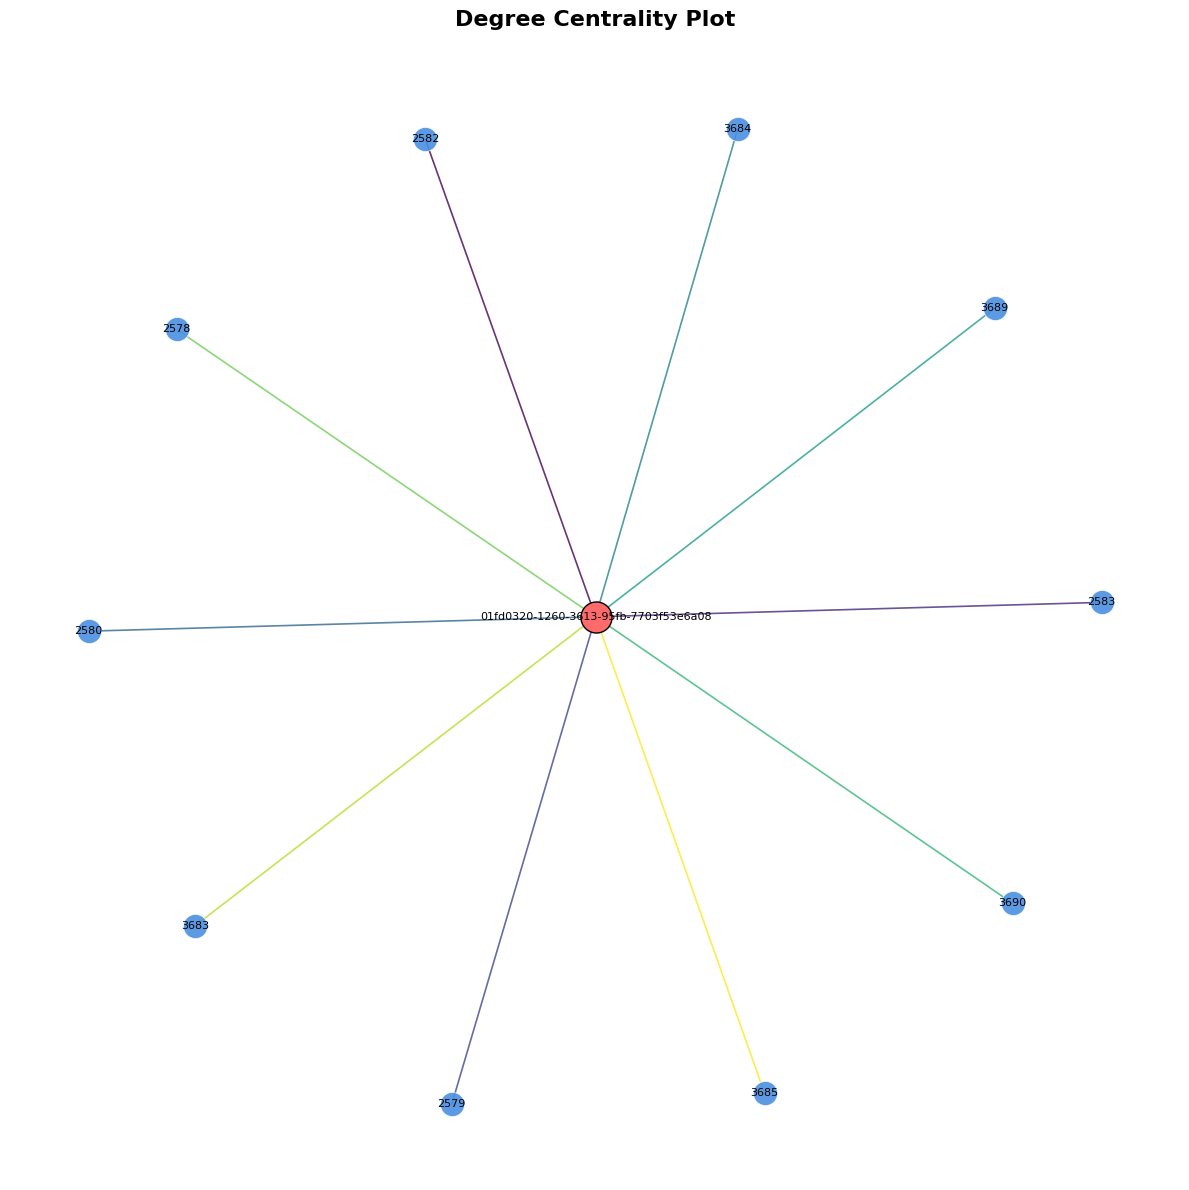

In [116]:
try:
  user_query = ""

  while not user_query:
    user_query = input("Enter the user query: ").strip()



  response = main(user_query=user_query)
  agent_type = response["agent_type"]

  print("\n----- Initial User query:\n", user_query)
  print("\n----- Modified User query:\n", response["modified_query"],"\n")

  # Matches the agent type
  match agent_type:

    case "aql":
      print(f'\n-------------------- Agent selected: AQL Agent because:\n{response["agent_type_reason"]}--------------------')
      aql_agent_response = aql_agent(user_query=user_query)
      print("\n-------------------- START RESPONSE: AQL Agent --------------------")
      print(aql_agent_response["result"])
      print("-------------------- END RESPONSE: AQL Agent --------------------\n")

    case "hybrid":
      print(f"\n-------------------- Agent selected: Hybrid Agent because:\n{response['agent_type_reason']} --------------------")

    case "networkX":
      print(f"\n-------------------- Finding the best specialised networkX agent for the user query --------------------")
      # Another LLM call to decide what specialised agent to go for within NetworkX
      specialised_agent_response = get_specialised_networkX_agent(user_query=response["modified_query"])

      print("\n--------------------")
      print(f"Using the {specialised_agent_response['specialised_agent']}\nBecause:{specialised_agent_response['specialised_agent_reason']}\nThe algorithm selected is:{specialised_agent_response['algorithm']}")
      print("--------------------\n")

      # Agent for the Degree Centrality
      if specialised_agent_response["specialised_agent"] == "degree_centrality":
        degree_centrality_agent_response = degree_centrality_agent(user_query=response["modified_query"])
        print("\n-------------------- Degree Centrality Agent Response: --------------------")
        pprint.pprint((degree_centrality_agent_response["messages"][-1]).content)

        # Shows the degree centrality verification results
        dc_verify()

        # Plots the graph
        if(response["is_visualisation_asked"]):
          # Function to plot the graph dynamically based on the user query and degree_centrality_agent_response
          dc_get_graph(user_query=user_query, dc_agent_response=degree_centrality_agent_response)

      else:
        print("The agent is not completed yet.")

    case _:
      print(response["not_relevant_message"])
except Exception as e:
  print(e)
  print("Something went wrong. Please try again later.")